In [1]:
import pandas as pd

In [2]:
df_final_sequence = pd.read_csv('df_final_sequence.csv')

In [3]:
df_final_sequence

,Protien Number,Sequence,Vaccine Candidate
0,A0A081UPN5,MSETKTNLLDLDRDAMRAFFVELGEKPFRADQVMKWIYHFGCDDFD...,0
1,A0A081UQL1,MTKQIKRIGVLTSGGDAPGMNAAIRAVVRAGLHHGLEVYGIYDGYL...,0
2,A0A0F6KC92,MKKVGLVGWRGMVGSVLMSRMQEEKDFSRIQPTFFTTSQAGEAAPN...,0
3,A0A0S3BF99,MPKKFYVSWDNLQREARRLARRQLPVSQWKGIIAVSRGGLVPAALM...,0
4,A0A0T6R2D4,MKKVGLVGWRGMVGSVLMSRMQEEQDFAHIQPTFFTTSQAGEAAPN...,0
...,...,...,...
521,AJE37222.1,MRDTTQVRAMDDYFHSLLLDDALLLDSSDEPDSAPVIQLQRQPQPV...,1
522,AJE37560.1,MEKVIFKRAALSAAIVAAMLAPGMVLAADEAGPTYAAAASKFYEEG...,1
523,AJE37735.1,MRNLTLLSLGLLAANAAHADLGEIPKQSGWSGFLLGGVNAVSYKSN...,1
524,AJE37742.1,MFKANGKGNAVRLVLSVATVAVLAACSSPQERKMANRGFEYEDARL...,1


In [5]:
### Generating Embeddings

In [8]:
import torch
import esm
from tqdm import tqdm
from transformers import AutoModel, AutoTokenizer

# Load the Hugging Face model and tokenizer
model = AutoModel.from_pretrained("facebook/esm2_t30_150M_UR50D")
tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t30_150M_UR50D")
model.eval()  # Disable dropout for evaluation

# Move model to CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Function to split sequences longer than 1022 into chunks
def split_sequence(sequence, chunk_size=1022):
    return [sequence[i:i + chunk_size] for i in range(0, len(sequence), chunk_size)]

# Function to generate embeddings
def generate_protein_embeddings(sequences, ids, batch_size=32):
    embeddings = {}
    for i in tqdm(range(0, len(sequences), batch_size)):
        batch_seqs = sequences[i:i + batch_size]
        batch_ids = ids[i:i + batch_size]
        
        for seq, id in zip(batch_seqs, batch_ids):
            # Split sequence if it's longer than 1022 residues
            chunks = split_sequence(seq) if len(seq) > 1022 else [seq]

            # Generate embeddings for each chunk and take the mean
            chunk_embeddings = []
            for chunk in chunks:
                inputs = tokenizer(chunk, return_tensors='pt', padding=True).to(device)
                with torch.no_grad():
                    outputs = model(**inputs)
                # Take mean of token embeddings from the last layer
                token_embeddings = outputs.last_hidden_state.mean(dim=1).squeeze(0)
                chunk_embeddings.append(token_embeddings)

            # Calculate the mean of all chunk embeddings
            combined_embedding = torch.stack(chunk_embeddings).mean(dim=0)
            embeddings[id] = combined_embedding.cpu().numpy()

    return embeddings

# Generate embeddings for the protein sequences
sequences = df_final_sequence['Sequence'].tolist()
ids = df_final_sequence['Protien Number'].tolist()
protein_embeddings = generate_protein_embeddings(sequences, ids)

# Now `protein_embeddings` will have embeddings for each protein number as a dictionary


Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t30_150M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 17/17 [00:21<00:00,  1.27s/it]


In [9]:
# Check the shape of each embedding to ensure consistency
embedding_shapes = set()
for protein_id, embedding in protein_embeddings.items():
    embedding_shapes.add(embedding.shape)
    # Optionally print the shape for each embedding
    print(f"Protein ID: {protein_id}, Embedding Shape: {embedding.shape}")

# Display unique shapes found
if len(embedding_shapes) == 1:
    print("All embeddings have the same shape:", embedding_shapes.pop())
else:
    print("Different embedding shapes found:", embedding_shapes)


Protein ID: A0A081UPN5, Embedding Shape: (640,)
Protein ID: A0A081UQL1, Embedding Shape: (640,)
Protein ID: A0A0F6KC92, Embedding Shape: (640,)
Protein ID: A0A0S3BF99, Embedding Shape: (640,)
Protein ID: A0A0T6R2D4, Embedding Shape: (640,)
Protein ID: A0A0T6SPP4, Embedding Shape: (640,)
Protein ID: A0A0T6U1G3, Embedding Shape: (640,)
Protein ID: A0A0T6UFK9, Embedding Shape: (640,)
Protein ID: A0A165RH90, Embedding Shape: (640,)
Protein ID: A0A165S9D4, Embedding Shape: (640,)
Protein ID: A0A165SDF0, Embedding Shape: (640,)
Protein ID: A0A165TAR6, Embedding Shape: (640,)
Protein ID: A0A1B8Z3K4, Embedding Shape: (640,)
Protein ID: A0A2R4TQI9, Embedding Shape: (640,)
Protein ID: A0A2R4TQX3, Embedding Shape: (640,)
Protein ID: A0A2R4TR28, Embedding Shape: (640,)
Protein ID: A0A2R4TS11, Embedding Shape: (640,)
Protein ID: A0A2R4TS98, Embedding Shape: (640,)
Protein ID: A0A2R4TSC6, Embedding Shape: (640,)
Protein ID: A0A2R4TUH4, Embedding Shape: (640,)
Protein ID: A0A2R4TUQ0, Embedding Shape:

In [10]:
# Convert embeddings dictionary to DataFrame
embedding_df = pd.DataFrame.from_dict(protein_embeddings, orient='index')
embedding_df.index.name = 'Protien Number'  # Ensure index name matches the column in df_final_sequence

# Reset index to join with df_final_sequence
embedding_df.reset_index(inplace=True)

# Merge the embeddings with df_final_sequence
df_final_sequence = df_final_sequence.merge(embedding_df, on='Protien Number', how='left')

In [11]:
df_final_sequence

,Protien Number,Sequence,Vaccine Candidate,0,1,2,3,4,5,6,...,630,631,632,633,634,635,636,637,638,639
0,A0A081UPN5,MSETKTNLLDLDRDAMRAFFVELGEKPFRADQVMKWIYHFGCDDFD...,0,-0.038111,-0.026883,-0.000614,-0.063177,0.055006,0.036491,-0.005557,...,-0.082823,-0.036510,0.020588,-0.013637,0.003912,-0.052443,-0.050889,-0.016623,-0.109427,-0.003069
1,A0A081UQL1,MTKQIKRIGVLTSGGDAPGMNAAIRAVVRAGLHHGLEVYGIYDGYL...,0,-0.125619,-0.070630,-0.006582,-0.060403,0.161851,0.017581,-0.004785,...,-0.065239,-0.070457,0.013707,-0.013592,-0.063521,0.025742,-0.096233,0.009414,-0.179594,-0.145452
2,A0A0F6KC92,MKKVGLVGWRGMVGSVLMSRMQEEKDFSRIQPTFFTTSQAGEAAPN...,0,0.018816,-0.078923,-0.078683,-0.011715,0.058420,0.019710,0.025389,...,-0.082951,-0.037765,-0.358283,-0.090527,-0.032247,0.013342,-0.005213,-0.032945,-0.089600,-0.024547
3,A0A0S3BF99,MPKKFYVSWDNLQREARRLARRQLPVSQWKGIIAVSRGGLVPAALM...,0,-0.042014,-0.137409,0.009741,-0.014019,-0.027253,-0.001259,0.026451,...,-0.075439,-0.014709,-0.214947,-0.021020,-0.131778,0.025642,-0.015276,-0.003691,-0.057814,-0.040517
4,A0A0T6R2D4,MKKVGLVGWRGMVGSVLMSRMQEEQDFAHIQPTFFTTSQAGEAAPN...,0,0.017402,-0.087016,-0.079623,-0.017289,0.070896,0.017167,0.027766,...,-0.085999,-0.044407,-0.362545,-0.083636,-0.037688,0.020056,0.005240,-0.033607,-0.090697,-0.021413
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
521,AJE37222.1,MRDTTQVRAMDDYFHSLLLDDALLLDSSDEPDSAPVIQLQRQPQPV...,1,0.113105,-0.108322,0.071104,-0.035429,0.187292,0.070366,0.095225,...,-0.023269,0.026326,-0.302948,0.061150,-0.123618,0.025197,0.018732,-0.155419,-0.111248,0.014223
522,AJE37560.1,MEKVIFKRAALSAAIVAAMLAPGMVLAADEAGPTYAAAASKFYEEG...,1,0.043055,-0.067447,-0.011981,0.078905,0.051042,0.028569,0.013305,...,0.062033,-0.117549,-0.409366,-0.139961,0.119814,0.110678,0.036373,0.006976,-0.179999,-0.006528
523,AJE37735.1,MRNLTLLSLGLLAANAAHADLGEIPKQSGWSGFLLGGVNAVSYKSN...,1,0.064316,-0.228732,-0.108717,-0.013516,0.209790,-0.048588,-0.000470,...,-0.030221,-0.071660,-0.361174,-0.173589,0.018985,0.180622,0.059118,-0.108138,0.020192,0.043806
524,AJE37742.1,MFKANGKGNAVRLVLSVATVAVLAACSSPQERKMANRGFEYEDARL...,1,0.079154,-0.143367,-0.084286,-0.001998,0.020457,0.080464,0.068989,...,-0.032874,-0.110926,-0.767147,-0.094820,-0.063644,0.084566,0.083537,-0.045985,-0.050931,0.042316


In [12]:
# Move the 'Vaccine Candidate' column to the end
columns = [col for col in df_final_sequence.columns if col != 'Vaccine Candidate'] + ['Vaccine Candidate']

# Reorder the DataFrame columns
df_final_sequence = df_final_sequence[columns]

# Display the reordered DataFrame
print(df_final_sequence.head())


  Protien Number                                           Sequence         0  \
0     A0A081UPN5  MSETKTNLLDLDRDAMRAFFVELGEKPFRADQVMKWIYHFGCDDFD... -0.038111   
1     A0A081UQL1  MTKQIKRIGVLTSGGDAPGMNAAIRAVVRAGLHHGLEVYGIYDGYL... -0.125619   
2     A0A0F6KC92  MKKVGLVGWRGMVGSVLMSRMQEEKDFSRIQPTFFTTSQAGEAAPN...  0.018816   
3     A0A0S3BF99  MPKKFYVSWDNLQREARRLARRQLPVSQWKGIIAVSRGGLVPAALM... -0.042014   
4     A0A0T6R2D4  MKKVGLVGWRGMVGSVLMSRMQEEQDFAHIQPTFFTTSQAGEAAPN...  0.017402   

          1         2         3         4         5         6         7  ...  \
0 -0.026883 -0.000614 -0.063177  0.055006  0.036491 -0.005557 -0.067594  ...   
1 -0.070630 -0.006582 -0.060403  0.161851  0.017581 -0.004785 -0.063303  ...   
2 -0.078923 -0.078683 -0.011715  0.058420  0.019710  0.025389 -0.044613  ...   
3 -0.137409  0.009741 -0.014019 -0.027253 -0.001259  0.026451 -0.136995  ...   
4 -0.087016 -0.079623 -0.017289  0.070896  0.017167  0.027766 -0.050070  ...   

        631       632       633 

In [14]:
df_final_sequence

,Protien Number,Sequence,0,1,2,3,4,5,6,7,...,631,632,633,634,635,636,637,638,639,Vaccine Candidate
0,A0A081UPN5,MSETKTNLLDLDRDAMRAFFVELGEKPFRADQVMKWIYHFGCDDFD...,-0.038111,-0.026883,-0.000614,-0.063177,0.055006,0.036491,-0.005557,-0.067594,...,-0.036510,0.020588,-0.013637,0.003912,-0.052443,-0.050889,-0.016623,-0.109427,-0.003069,0
1,A0A081UQL1,MTKQIKRIGVLTSGGDAPGMNAAIRAVVRAGLHHGLEVYGIYDGYL...,-0.125619,-0.070630,-0.006582,-0.060403,0.161851,0.017581,-0.004785,-0.063303,...,-0.070457,0.013707,-0.013592,-0.063521,0.025742,-0.096233,0.009414,-0.179594,-0.145452,0
2,A0A0F6KC92,MKKVGLVGWRGMVGSVLMSRMQEEKDFSRIQPTFFTTSQAGEAAPN...,0.018816,-0.078923,-0.078683,-0.011715,0.058420,0.019710,0.025389,-0.044613,...,-0.037765,-0.358283,-0.090527,-0.032247,0.013342,-0.005213,-0.032945,-0.089600,-0.024547,0
3,A0A0S3BF99,MPKKFYVSWDNLQREARRLARRQLPVSQWKGIIAVSRGGLVPAALM...,-0.042014,-0.137409,0.009741,-0.014019,-0.027253,-0.001259,0.026451,-0.136995,...,-0.014709,-0.214947,-0.021020,-0.131778,0.025642,-0.015276,-0.003691,-0.057814,-0.040517,0
4,A0A0T6R2D4,MKKVGLVGWRGMVGSVLMSRMQEEQDFAHIQPTFFTTSQAGEAAPN...,0.017402,-0.087016,-0.079623,-0.017289,0.070896,0.017167,0.027766,-0.050070,...,-0.044407,-0.362545,-0.083636,-0.037688,0.020056,0.005240,-0.033607,-0.090697,-0.021413,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
521,AJE37222.1,MRDTTQVRAMDDYFHSLLLDDALLLDSSDEPDSAPVIQLQRQPQPV...,0.113105,-0.108322,0.071104,-0.035429,0.187292,0.070366,0.095225,-0.141964,...,0.026326,-0.302948,0.061150,-0.123618,0.025197,0.018732,-0.155419,-0.111248,0.014223,1
522,AJE37560.1,MEKVIFKRAALSAAIVAAMLAPGMVLAADEAGPTYAAAASKFYEEG...,0.043055,-0.067447,-0.011981,0.078905,0.051042,0.028569,0.013305,0.104298,...,-0.117549,-0.409366,-0.139961,0.119814,0.110678,0.036373,0.006976,-0.179999,-0.006528,1
523,AJE37735.1,MRNLTLLSLGLLAANAAHADLGEIPKQSGWSGFLLGGVNAVSYKSN...,0.064316,-0.228732,-0.108717,-0.013516,0.209790,-0.048588,-0.000470,0.140135,...,-0.071660,-0.361174,-0.173589,0.018985,0.180622,0.059118,-0.108138,0.020192,0.043806,1
524,AJE37742.1,MFKANGKGNAVRLVLSVATVAVLAACSSPQERKMANRGFEYEDARL...,0.079154,-0.143367,-0.084286,-0.001998,0.020457,0.080464,0.068989,0.054654,...,-0.110926,-0.767147,-0.094820,-0.063644,0.084566,0.083537,-0.045985,-0.050931,0.042316,1


In [16]:
# Save the DataFrame with embeddings to a CSV file
df_final_sequence.to_csv("df_final_sequence_with_embeddings.csv", index=False)


In [15]:
### XGBoost

In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, log_loss
from xgboost import XGBClassifier
from tqdm import tqdm

# Split into features and target
X = df_final_sequence.drop(['Protien Number', 'Sequence', 'Vaccine Candidate'], axis=1)
y = df_final_sequence['Vaccine Candidate']

# Scale the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Set up cross-validation
cv = KFold(n_splits=10, random_state=42, shuffle=True)

# Initialize score lists
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
roc_auc_scores = []
log_losses = []

# Cross-validation loop with progress bar
for train_index, test_index in tqdm(cv.split(X), total=cv.get_n_splits(), desc="Cross-validation folds"):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Initialize XGBoost model for CPU
    model_xgb = XGBClassifier(n_estimators=100, random_state=42, eval_metric="logloss", tree_method="hist")
    
    # Train the model
    model_xgb.fit(X_train, y_train)
    
    # Predict
    y_pred = model_xgb.predict(X_test)
    y_pred_prob = model_xgb.predict_proba(X_test)[:, 1]  # Probability for positive class
    
    # Calculate metrics
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    precision_scores.append(precision_score(y_test, y_pred))
    recall_scores.append(recall_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
    roc_auc_scores.append(roc_auc_score(y_test, y_pred_prob))
    log_losses.append(log_loss(y_test, y_pred_prob))

# Print average metrics
print('Average accuracy:', np.mean(accuracy_scores))
print('Average precision:', np.mean(precision_scores))
print('Average recall:', np.mean(recall_scores))
print('Average F1-score:', np.mean(f1_scores))
print('Average ROC-AUC score:', np.mean(roc_auc_scores))
print('Average Log Loss:', np.mean(log_losses))


Cross-validation folds: 100%|██████████| 10/10 [00:04<00:00,  2.19it/s]

Average accuracy: 0.9355224963715528
Average precision: 0.9555555555555555
Average recall: 0.6631607281607281
Average F1-score: 0.7620999614420667
Average ROC-AUC score: 0.9307198290132572
Average Log Loss: 0.27096721460837897


Accuracy: 0.9150943396226415
Precision: 1.0
Recall: 0.6666666666666666
F1-score: 0.8
ROC-AUC score: 0.9634317862165963
Log Loss: 0.32484435497708547


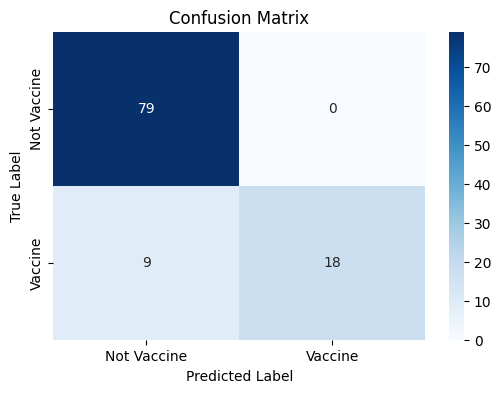

In [25]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, log_loss, confusion_matrix
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt

# Split into features and target
X = df_final_sequence.drop(['Protien Number', 'Sequence', 'Vaccine Candidate'], axis=1)
y = df_final_sequence['Vaccine Candidate']

# Scale the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize XGBoost model
model_xgb = XGBClassifier(n_estimators=100, random_state=42, eval_metric="logloss", tree_method="hist")

# Train the model
model_xgb.fit(X_train, y_train)

# Predict
y_pred = model_xgb.predict(X_test)
y_pred_prob = model_xgb.predict_proba(X_test)[:, 1]  # Probability for positive class

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)
log_loss_val = log_loss(y_test, y_pred_prob)

# Print metrics
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')
print(f'ROC-AUC score: {roc_auc}')
print(f'Log Loss: {log_loss_val}')

# Generate and plot the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Vaccine", "Vaccine"], yticklabels=["Not Vaccine", "Vaccine"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
